In [1]:
import os
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
RAW_DATA_DIR = "../data/raw/"

In [3]:
def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
customers = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_customers_dataset.csv', engine="pyarrow"))
geolocation = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_geolocation_dataset.csv', engine="pyarrow"))
orders = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_orders_dataset.csv', engine="pyarrow"))
order_items = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_items_dataset.csv', engine="pyarrow"))
order_payments = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_payments_dataset.csv', engine="pyarrow"))
order_reviews = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_reviews_dataset.csv', engine="pyarrow"))
products = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_products_dataset.csv', engine="pyarrow"))
sellers = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_sellers_dataset.csv', engine="pyarrow"))
product_category_translation = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'product_category_name_translation.csv', engine="pyarrow"))

In [5]:
def skim(data):
    print(f'''number of rows: {data.shape[0]}''')
#number of columns: {data.shape[1]}''')
    summary = pd.DataFrame({
                    'column': data.columns.values,
                    'type': data.dtypes.values,
                    'n_unique': data.nunique().values,
                    'n_missing': data.isna().sum().reset_index()[0],
                    'pct_missing': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                    'min': data.dropna().min().values,
                    'max': data.dropna().max().values
                })
    return summary

## `Handling Duplicates`

### **Orders Dataset**

In [6]:
skim(orders)

number of rows: 99441


,column,type,n_unique,n_missing,pct_missing,min,max
0,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
1,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8
2,order_status,object,8,0,0.00,canceled,delivered
3,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-09-15 12:16:38,2018-08-29 15:00:37
4,order_approved_at,datetime64[ns],90733,160,0.16,2016-09-15 12:16:38,2018-08-29 15:10:26
5,order_delivered_carrier_date,datetime64[ns],81018,1783,1.79,2016-10-08 10:34:01,2018-09-11 19:48:28
6,order_delivered_customer_date,datetime64[ns],95664,2965,2.98,2016-10-11 13:46:32,2018-10-17 13:22:46
7,order_estimated_delivery_date,datetime64[ns],459,0,0.00,2016-10-04 00:00:00,2018-10-25 00:00:00


In [7]:
orders[orders.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


**Insight:**
<br>Tidak ada duplicated values

### **Order Items Dataset**

In [8]:
skim(order_items)

number of rows: 112650


,column,type,n_unique,n_missing,pct_missing,min,max
0,order_id,object,98666,0,0.0,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
1,order_item_id,int64,21,0,0.0,1,21
2,product_id,object,32951,0,0.0,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58
3,seller_id,object,3095,0,0.0,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726
4,shipping_limit_date,datetime64[ns],93318,0,0.0,2016-09-19 00:15:34,2020-04-09 22:35:08
5,price,float64,5968,0,0.0,0.85,6735.0
6,freight_value,float64,6999,0,0.0,0.0,409.68


In [9]:
order_items[order_items.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [10]:
order_items[order_items.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "order_item_id"])

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112635,fff8287bbae429a99bb7e8c21d151c41,2,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


**Insight:**<br>
Duplicated values di kolom order_id, satu order bisa terdiri dari beberapa item sehingga tidak perlu handling lebih lanjut

### **Products & Product Category Translation Dataset**

In [11]:
skim(products)

number of rows: 32951


,column,type,n_unique,n_missing,pct_missing,min,max
0,product_id,object,32951,0,0.00,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58
1,product_category_name,object,73,610,1.85,agro_industria_e_comercio,utilidades_domesticas
2,product_name_lenght,float64,66,610,1.85,5.0,76.0
3,product_description_lenght,float64,2960,610,1.85,4.0,3992.0
4,product_photos_qty,float64,19,610,1.85,1.0,20.0
5,product_weight_g,float64,2204,2,0.01,0.0,40425.0
6,product_length_cm,float64,99,2,0.01,7.0,105.0
7,product_height_cm,float64,102,2,0.01,2.0,105.0
8,product_width_cm,float64,95,2,0.01,6.0,118.0


In [12]:
products[products.duplicated()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


**Insight:**
<br>Tidak ada duplicated values

In [13]:
skim(product_category_translation)

number of rows: 71


,column,type,n_unique,n_missing,pct_missing,min,max
0,product_category_name,object,71,0,0.0,agro_industria_e_comercio,utilidades_domesticas
1,product_category_name_english,object,71,0,0.0,agro_industry_and_commerce,watches_gifts


In [14]:
product_category_translation[product_category_translation.duplicated()]

,product_category_name,product_category_name_english


**Insight:**
<br>Tidak ada duplicated values
<br>Jumlah unique value dari product category name di dataset products (73) dan product_category_translation (71) berbeda

In [15]:
product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_tmp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
merged_tmp[merged_tmp["product_category_name_english"].isna()]

,product_category_name,product_category_name_english
63,pc_gamer,NaN
69,portateis_cozinha_e_preparadores_de_alimentos,NaN


**Insight:**
<br>Kategori pc_gamer dan portateis_cozinha_e_preparadores_de_alimentos	tidak mempunyai terjemahan dalam bahasa Inggris, **solusi: terjemahan akan ditambahkan sebagai pc_gamer dan portable_kitchen_and_food_processors**

In [16]:
new_category = pd.DataFrame({"product_category_name": ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                             "product_category_name_english": ["pc_gamer", "portable_kitchen_and_food_processors"]})
product_category_translation = pd.concat([product_category_translation, new_category], ignore_index=True)

In [17]:
category_duplicates = merged_tmp[merged_tmp["product_category_name"].str.contains("_2")]
category_duplicates

,product_category_name,product_category_name_english
43,eletrodomesticos_2,home_appliances_2
68,casa_conforto_2,home_comfort_2


In [18]:
merged_tmp[merged_tmp["product_category_name"].isin(category_duplicates["product_category_name"].str.rstrip("_2"))]

,product_category_name,product_category_name_english
8,eletrodomesticos,home_appliances
50,casa_conforto,home_confort


**Insight:**
<br>Ada duplikasi kategori yaitu eletrodomesticos_2 dan casa_conforto_2, **solusi: kedua kategori akan diganti menjadi eletrodomesticos dan casa_conforto**

In [19]:
products.replace(to_replace="_2", value="", regex=True, inplace=True)
product_category_translation = product_category_translation[~product_category_translation["product_category_name"].str.contains("_2")]

product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_tmp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
skim(merged_tmp)

number of rows: 71


,column,type,n_unique,n_missing,pct_missing,min,max
0,product_category_name,object,71,0,0.0,agro_industria_e_comercio,utilidades_domesticas
1,product_category_name_english,object,71,0,0.0,agro_industry_and_commerce,watches_gifts


**Insight:**
<br>Duplicated dan missing values berhasil ditangani. Jumlah unique value akhir dari product_category adalah 71 (=73-2, karena ada dua kategori duplikasi)

### **Customers Dataset**

In [20]:
skim(customers)

number of rows: 99441


,column,type,n_unique,n_missing,pct_missing,min,max
0,customer_id,object,99441,0,0.0,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99
1,customer_unique_id,object,96096,0,0.0,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb
2,customer_zip_code_prefix,int64,14994,0,0.0,1003,99990
3,customer_city,object,4119,0,0.0,abadia dos dourados,zortea
4,customer_state,object,27,0,0.0,AC,TO


In [21]:
customers[customers.duplicated()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [22]:
customers[customers.duplicated(subset=["customer_unique_id"], keep=False)].sort_values(by="customer_unique_id")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
19299,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL
...,...,...,...,...,...
75057,1ae563fdfa500d150be6578066d83998,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
27992,bec0bf00ac5bee64ce8ef5283051a70c,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
79859,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
64323,4b231c90751c27521f7ee27ed2dc3b8f,ffe254cc039740e17dd15a5305035928,37640,extrema,MG


**Insight:**
<br>Duplicated values di kolom customer_unique_id, satu unik customer bisa mempunyai beberapa ID sehingga tidak perlu handling lebih lanjut

### **Order Payments Dataset**

In [23]:
skim(order_payments)

number of rows: 103886


,column,type,n_unique,n_missing,pct_missing,min,max
0,order_id,object,99440,0,0.0,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
1,payment_sequential,int64,29,0,0.0,1,29
2,payment_type,object,5,0,0.0,boleto,voucher
3,payment_installments,int64,24,0,0.0,0,24
4,payment_value,float64,29077,0,0.0,0.0,13664.08


In [24]:
order_payments[order_payments.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [25]:
order_payments[order_payments.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "payment_sequential"])

,order_id,payment_sequential,payment_type,payment_installments,payment_value
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


**Insight:**
<br>Duplicated values di kolom order_id, satu order bisa memiliki pembayaran bertahap sehingga tidak perlu handling lebih lanjut

### **Order Reviews Dataset**

In [26]:
skim(order_reviews)

number of rows: 99224


,column,type,n_unique,n_missing,pct_missing,min,max
0,review_id,object,98410,0,0.00,00020c7512a52e92212f12d3e37513c0,ffec6410b1f1d834f07afcc4800f2f2e
1,order_id,object,98673,0,0.00,0006ec9db01a64e59a68b2c340bf65a7,ffea20c7630343a6cd9e09858c1295cd
2,review_score,int64,5,0,0.00,1,5
3,review_comment_title,object,4526,87658,88.34,10,🔟
4,review_comment_message,object,36155,58274,58.73,\r\nBoa\r\nDemais\r\nA entrega\r\n,😀
5,review_creation_date,datetime64[ns],636,0,0.00,2017-05-16 00:00:00,2018-08-31 00:00:00
6,review_answer_timestamp,datetime64[ns],98248,0,0.00,2018-04-26 12:56:00,2018-10-24 21:34:38


In [27]:
order_reviews.sort_values(by=["order_id", "review_answer_timestamp"], ignore_index=True, inplace=True)

In [28]:
order_reviews[order_reviews.duplicated()]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [29]:
order_reviews[order_reviews.duplicated(subset=["review_id"], keep=False)].sort_values(by=["review_id"])

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
86911,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
1820,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
46708,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
4935,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
96579,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53
...,...,...,...,...,...,...,...
82136,fe5c833752953fed3209646f1f63b53c,d3775e436e60258e62e678a0f68a0f8d,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ...",2018-02-28,2018-02-28 13:57:52
17582,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
6434,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
77765,ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,2017-07-22,2017-07-26 13:41:07


In [30]:
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
84,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25,2017-08-29 21:45:57
85,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29,2017-08-30 01:59:12
462,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22,2018-02-23 12:12:30
463,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04,2018-03-05 17:02:00
558,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
99029,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18,2017-11-18 09:02:48
99046,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16,2017-08-17 11:56:55
99047,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22,2017-08-25 11:40:22
99103,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20,2017-12-20 18:50:16


**Insight**:
* Duplicated values di kolom review_id dan order_id
* Asumsi duplicated values di kolom review_id terjadi ketika customer melakukan review untuk beberapa order dalam satu waktu, tidak perlu handling lebih lanjut
* Asumsi duplicated values di kolom order_id terjadi ketika customer berubah pikiran dari review yang sebelumnya sudah dibuat, **solusi: mengambil review terbaru berdasarkan kolom review_answer_timestamp**

In [31]:
order_reviews.drop_duplicates(subset=["order_id"], keep="last", ignore_index=True, inplace=True)
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


### **Sellers Dataset**

In [32]:
skim(sellers)

number of rows: 3095


,column,type,n_unique,n_missing,pct_missing,min,max
0,seller_id,object,3095,0,0.0,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726
1,seller_zip_code_prefix,int64,2246,0,0.0,1001,99730
2,seller_city,object,611,0,0.0,04482255,xaxim
3,seller_state,object,23,0,0.0,AC,SP


In [33]:
sellers[sellers.duplicated()]

,seller_id,seller_zip_code_prefix,seller_city,seller_state


**Insight:**
<br>Tidak ada duplicated values

### **Geolocation Dataset**

In [34]:
skim(geolocation)

number of rows: 1000163


,column,type,n_unique,n_missing,pct_missing,min,max
0,geolocation_zip_code_prefix,int64,19015,0,0.0,1001,99990
1,geolocation_lat,float64,717372,0,0.0,-36.605374,45.065933
2,geolocation_lng,float64,717615,0,0.0,-101.466766,121.105394
3,geolocation_city,object,8011,0,0.0,* cidade,óleo
4,geolocation_state,object,27,0,0.0,AC,TO


In [35]:
geolocation[geolocation.duplicated()].sort_values(by="geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1435,1001,-23.549292,-46.633559,sao paulo,SP
771,1001,-23.550498,-46.634338,sao paulo,SP
596,1001,-23.550498,-46.634338,sao paulo,SP
1004,1001,-23.549292,-46.633559,sao paulo,SP
1246,1001,-23.549292,-46.633559,sao paulo,SP
...,...,...,...,...,...
1000045,99980,-28.388342,-51.845194,david canabarro,RS
1000129,99980,-28.387059,-51.848964,david canabarro,RS
1000002,99980,-28.388342,-51.845194,david canabarro,RS
1000133,99980,-28.386689,-51.847091,david canabarro,RS


**Insight:**
<br>Duplicated values di kolom geolocation_zip_code_prefix, satu zip code bisa terdiri dari berbagai titik koordinat lokasi sehingga tidak perlu handling lebih lanjut

In [36]:
customer_zip_code = set(customers["customer_zip_code_prefix"])
geolocation_zip_code = set(geolocation["geolocation_zip_code_prefix"])
zip_code_missing = customer_zip_code - geolocation_zip_code

In [37]:
zip_code_missing.issubset(customer_zip_code)

True

In [38]:
zip_code_missing.issubset(geolocation_zip_code)

False

## `Merge Datasets`

In [39]:
master_data = orders.merge(order_items, on="order_id", how="left")
master_data.shape

(113425, 14)

In [40]:
master_data = master_data.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
master_data.shape

(113425, 15)

In [41]:
master_data = master_data.merge(product_category_translation, on="product_category_name", how="left")
master_data.shape

(113425, 16)

In [42]:
master_data = master_data.merge(customers, on="customer_id", how="left")
master_data.shape

(113425, 20)

In [43]:
master_data = master_data.merge(order_payments, on="order_id", how="left")
master_data.shape

(118434, 24)

In [44]:
master_data = master_data.merge(order_reviews[["order_id", "review_score"]], on="order_id", how="left")
master_data.shape

(118434, 25)

In [45]:
# master_data = master_data.merge(sellers, on="seller_id", how="left")
# master_data.shape

In [46]:
master_data.sort_values(by="order_purchase_timestamp", inplace=True)

In [47]:
skim(master_data)

number of rows: 118434


,column,type,n_unique,n_missing,pct_missing,min,max
0,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
1,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8
2,order_status,object,8,0,0.00,canceled,delivered
3,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-10-03 09:44:50,2018-08-29 15:00:37
4,order_approved_at,datetime64[ns],90733,176,0.15,2016-10-04 09:43:32,2018-08-29 15:10:26
5,order_delivered_carrier_date,datetime64[ns],81018,2074,1.75,2016-10-08 10:34:01,2018-09-11 19:48:28
6,order_delivered_customer_date,datetime64[ns],95664,3397,2.87,2016-10-11 13:46:32,2018-10-17 13:22:46
7,order_estimated_delivery_date,datetime64[ns],459,0,0.00,2016-10-27 00:00:00,2018-10-25 00:00:00
8,order_item_id,float64,21,830,0.70,1.0,21.0
9,product_id,object,32951,830,0.70,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58


## `Data Types`

IDs (6):
* order_id
* customer_id
* order_item_id
* product_id
* seller_id
* customer_unique_id

Categorical (7):
* order_status, low cardinality (8)
* product_category_name, high cardinality (72)
* product_category_name_english, high cardinality (72)
* customer_zip_code_prefix, high cardinality (14994)
* customer_city, high cardinality (4119)
* customer_state, high cardinality (27)
* payment_type, low cardinality low (5)

Datetime (6):
* order_purchase_timestamp
* order_approved_at
* order_delivered_carrier_date
* order_delivered_customer_date
* order_estimated_delivery_date
* shipping_limit_date

Numerical, Continuous (3):
* price
* freight_value
* payment_value

Numerical, Ordinal (3):
* review_score
* payment_sequential, high cardinality (26)
* payment_installments, high cardinality (24)

## `Handling Ambiguity`

## `Handling Missing Values`

In [48]:
n_rows_orig = len(master_data)
n_rows_clean = len(master_data.dropna())
print(f'''n_rows original: {n_rows_orig}
n_rows with NaNs: {n_rows_orig-n_rows_clean}
% rows with Nans: {round((n_rows_orig-n_rows_clean)/n_rows_orig*100,2)}
n_rows clean: {n_rows_clean}''')

n_rows original: 118434
n_rows with NaNs: 5892
% rows with Nans: 4.97
n_rows clean: 112542


In [49]:
master_data[master_data["customer_zip_code_prefix"].isin(zip_code_missing)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_score
37168,8300640f8328abe9ac6691e4caf3c2bf,1e0918f0d58bd46e2465857831ec892c,invoiced,2017-02-09 15:27:30,2017-02-09 15:35:18,NaT,NaT,2017-03-14,1.0,ea99388f66ccc3a78b6c2d7725184b12,6d66611d7c44cc30ce351abc49a68421,2017-02-13 15:27:30,49.90,16.78,esporte_lazer,sports_leisure,f0659077678fd05b5346a8afbf216c16,72280,brasilia,DF,1.0,credit_card,4.0,66.68,1.0
73482,0dc2734aeb43fcd6b5c4a6d6296f50c5,aacd2c89b47bcc2aa875ea9b1f64955d,delivered,2017-03-02 09:21:19,2017-03-04 02:25:17,2017-03-08 07:09:45,2017-03-29 10:58:07,2017-03-29,1.0,33202a8e7a645388c41ed714203d7131,8d79c8a04e42d722a75097ce5cbcf2ef,2017-03-09 02:25:17,149.90,27.48,alimentos,food,a33bb670bdfc972c485c44923aece1df,42843,jaua,BA,1.0,boleto,1.0,177.38,5.0
45047,6d5e1e480d92f1bde5e9eb187fa388d5,4f3d7e6bbe7f1c9de320437cf6bf04d8,delivered,2017-03-02 12:33:10,2017-03-03 09:01:53,2017-03-03 15:21:10,2017-03-14 09:47:51,2017-03-28,1.0,12587360502d12268a9841080015d52a,fa1c13f2614d7b5c4749cbc52fecda94,2017-03-10 09:01:53,119.90,16.54,relogios_presentes,watches_gifts,150e414ff9f93eae86f42f44c8c863c8,71884,brasilia,DF,1.0,credit_card,2.0,86.44,5.0
45046,6d5e1e480d92f1bde5e9eb187fa388d5,4f3d7e6bbe7f1c9de320437cf6bf04d8,delivered,2017-03-02 12:33:10,2017-03-03 09:01:53,2017-03-03 15:21:10,2017-03-14 09:47:51,2017-03-28,1.0,12587360502d12268a9841080015d52a,fa1c13f2614d7b5c4749cbc52fecda94,2017-03-10 09:01:53,119.90,16.54,relogios_presentes,watches_gifts,150e414ff9f93eae86f42f44c8c863c8,71884,brasilia,DF,2.0,voucher,1.0,50.00,5.0
62673,056349f85a73d794119c4286c95a52de,03bbe0ce5c28e05f22917607db798818,delivered,2017-03-03 14:21:58,2017-03-03 14:35:09,2017-03-03 16:08:50,2017-03-17 12:52:17,2017-03-28,1.0,af35be35db4ad0dc288b571453337376,d20b021d3efdf267a402c402a48ea64b,2017-03-09 14:35:09,10.99,16.05,moveis_decoracao,furniture_decor,8f3dca4306d5a89e4ae2c65c110603a2,72465,brasilia,DF,1.0,credit_card,2.0,27.04,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76830,edf5259d2b67344bab205bdd705eb9f8,d0de9a1f4f99b1ef24d62e647e0e2320,delivered,2018-08-19 17:22:42,2018-08-20 12:30:29,2018-08-21 11:48:00,2018-08-27 16:25:24,2018-09-04,1.0,94eecc7cef7bc0bb31e2c26526efdd0a,cc5a78bbad32776dc4e3af205218368c,2018-08-22 12:30:29,68.88,44.28,utilidades_domesticas,housewares,339f34206b47320a2fce8cb2197e13cb,71993,brasilia,DF,1.0,credit_card,4.0,113.16,5.0
81559,ddb860efe17d6082630b99db1200b1c0,dfe533d0707629488eb4571a6dd315cd,delivered,2018-08-20 09:09:53,2018-08-20 14:35:50,2018-08-21 14:29:00,2018-08-27 22:03:33,2018-09-06,1.0,0d954479e7991c06d35202c130844b57,5c6d4016c2a288f074fa0848a2b653d2,2018-08-23 14:31:37,132.00,17.11,informatica_acessorios,computers_accessories,1ac4011bec2c0d9ce8eceb56bb1142c7,71995,brasilia,DF,1.0,credit_card,2.0,149.11,5.0
68090,4cf8e5fafb46ec3ef4e9b76e9eb2bf25,17679c354e803265772e7ebda35857eb,delivered,2018-08-21 07:07:54,2018-08-21 07:30:14,2018-08-22 11:18:00,2018-08-29 20:38:53,2018-09-19,1.0,25707e90c7f4f672f8d1058a32d78982,0be8ff43f22e456b4e0371b2245e4d01,2018-08-24 07:30:14,57.90,18.56,esporte_lazer,sports_leisure,bd315e83bbf6540e7d45fd73b5e41bdd,41098,salvador,BA,1.0,credit_card,1.0,76.46,5.0
51215,76cc0d927131093087a3d392008d9796,ce235b7711c4350b82cbeab0568b7df2,delivered,2018-08-22 02:16:10,2018-08-22 02:30:17,2018-08-23 13:55:00,2018-08-30 10:58:42,2018-09-18,1.0,c50ca07e9e4db9ea5011f06802c0aea0,9b013e03b2ab786505a1d3b5c0756754,2018-08-27 02:30:17,19.49,18.24,beleza_saude,health_beauty,6550bfddbb6eb18f5cfc4d8e410c485a,83210,paranagua,PR,1.0,credit_card,1.0,37.73,5.0


## `Handling Outliers`

In [50]:
df_notna = master_data.dropna()
df_notna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112542 entries, 111022 to 104766
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112542 non-null  object        
 1   customer_id                    112542 non-null  object        
 2   order_status                   112542 non-null  object        
 3   order_purchase_timestamp       112542 non-null  datetime64[ns]
 4   order_approved_at              112542 non-null  datetime64[ns]
 5   order_delivered_carrier_date   112542 non-null  datetime64[ns]
 6   order_delivered_customer_date  112542 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112542 non-null  datetime64[ns]
 8   order_item_id                  112542 non-null  float64       
 9   product_id                     112542 non-null  object        
 10  seller_id                      112542 non-null  object        
 11  

### **Numerical, Continuous**

In [51]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, title=None, column=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    if title:
        axes[0].set_title(title)
    plt.show();

In [52]:
def detect_bounds(data, method="iqr"):
    if method == "iqr":
        q1, q3 = np.percentile(data, 25), np.percentile(data, 75)
        iqr = q3 - q1
        lower, upper = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
    if method == "mad":
        med = data.median()
        mad = abs(data - med).median()
        lower, upper = med - mad, med + mad
    print(f"outlier lower threshold using {method}: {lower}")
    print(f"outlier upper threshold using {method}: {upper}")
    print()
    return lower, upper

In [53]:
tmp = pd.DataFrame(columns=['variable', 'method', 'upper_threshold', 'n_outlier', 'pct_outlier'])
for col in ["price", "freight_value", "payment_value"]:
    print(f"=== {col} ===")
    for method in ["iqr", "mad"]:
        _, thres = detect_bounds(df_notna[col], method=method)
        thres = round(thres, 2)
        str_thres = f'${thres}'
        n_outlier = len(df_notna[df_notna[col]>thres])
        pct_outlier = round((n_outlier/len(df_notna))*100,2)
        tmp.loc[len(tmp)] = [col, method, str_thres, n_outlier, pct_outlier]
tmp

=== price ===
outlier lower threshold using iqr: -100.75124999999997
outlier upper threshold using iqr: 274.31874999999997

outlier lower threshold using mad: 32.99
outlier upper threshold using mad: 116.81

=== freight_value ===
outlier lower threshold using iqr: 0.9149999999999974
outlier upper threshold using iqr: 33.355000000000004

outlier lower threshold using mad: 12.69
outlier upper threshold using mad: 19.950000000000003

=== payment_value ===
outlier lower threshold using iqr: -131.565
outlier upper threshold using iqr: 381.595

outlier lower threshold using mad: 51.43
outlier upper threshold using mad: 164.57



,variable,method,upper_threshold,n_outlier,pct_outlier
0,price,iqr,$274.32,8440,7.50
1,price,mad,$116.81,34707,30.84
2,freight_value,iqr,$33.36,11590,10.30
3,freight_value,mad,$19.95,31570,28.05
4,payment_value,iqr,$381.6,9035,8.03
5,payment_value,mad,$164.57,34461,30.62


#### **Price**

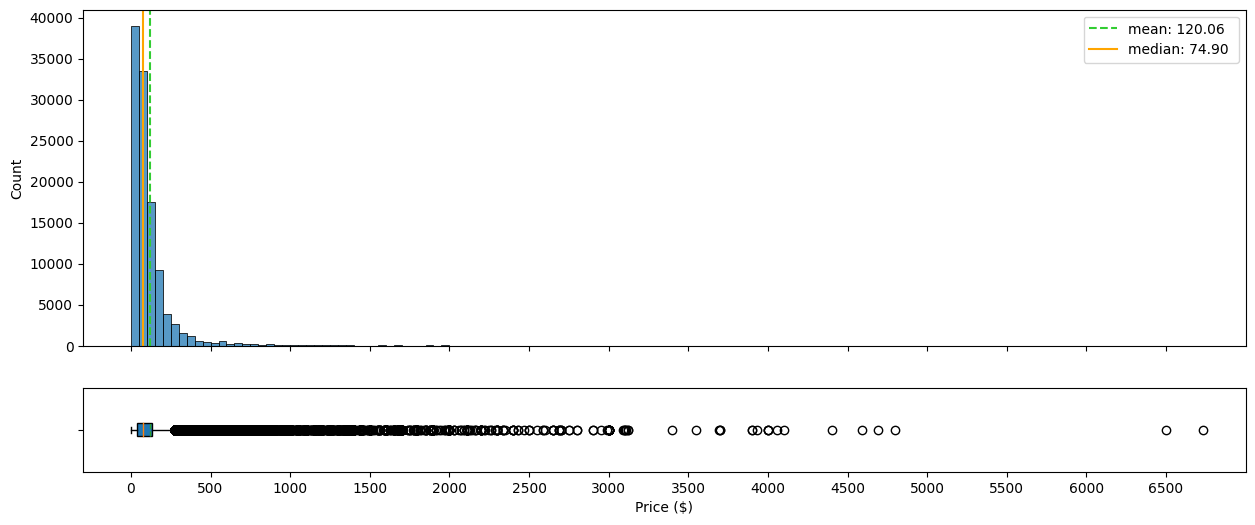

In [54]:
distboxplot(data=df_notna, column="price", bins=np.arange(0,7000,50),
            xticks=np.arange(0,7000,500), xlim=[-300,7000], xlabel="Price ($)", unit="",
            title=None, figsize=(15,6))

#### **Freight Value**

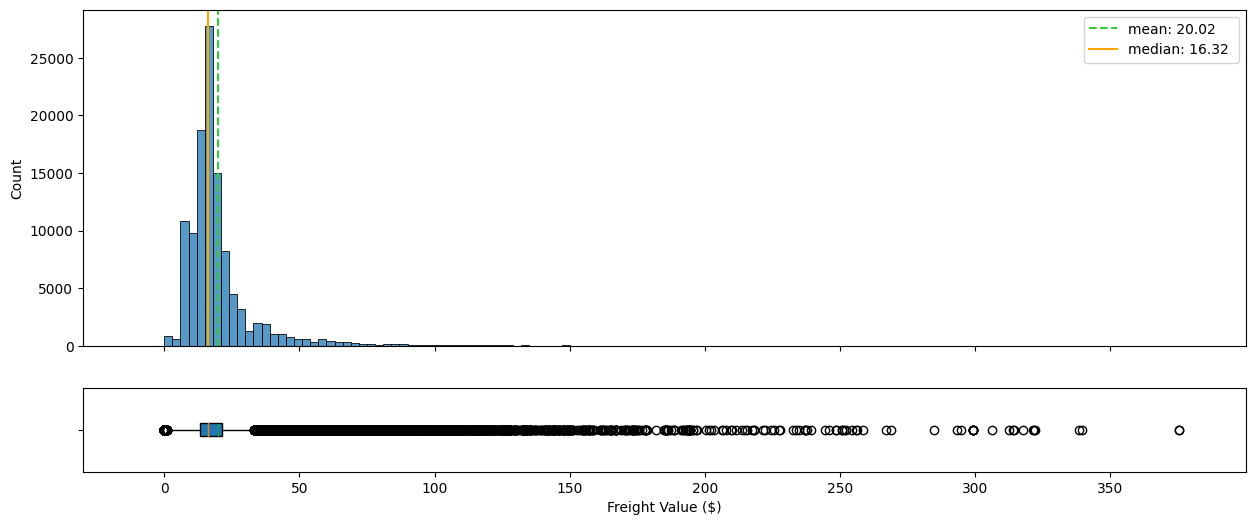

In [55]:
distboxplot(data=df_notna, column="freight_value", bins=np.arange(0,400,3),
            xticks=np.arange(0,400,50), xlim=[-30,400], xlabel="Freight Value ($)", unit="",
            title=None, figsize=(15,6))

#### **Payment Value**

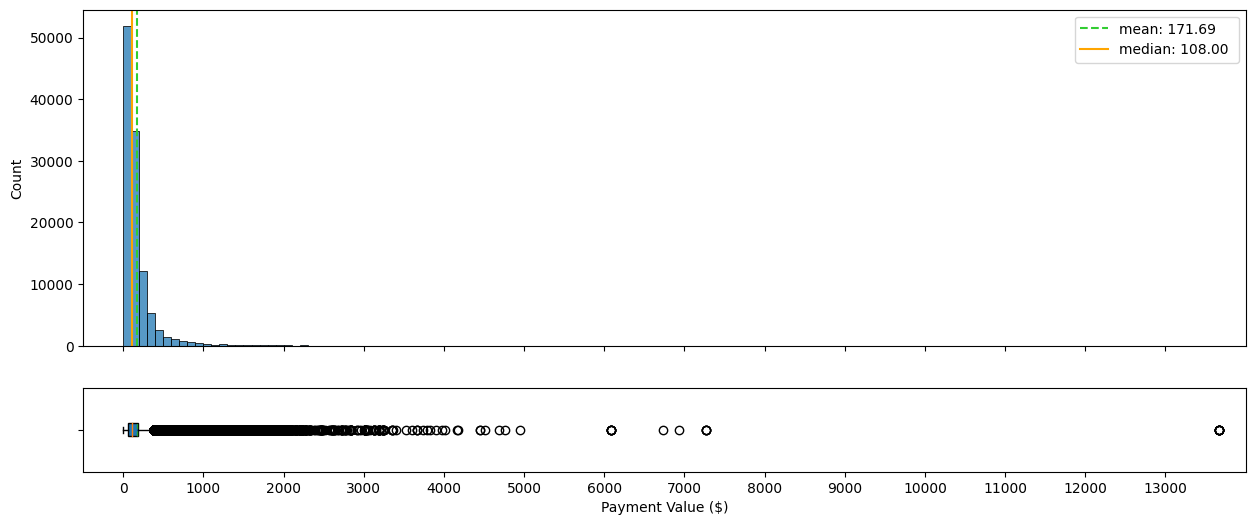

In [56]:
distboxplot(data=df_notna, column="payment_value", bins=np.arange(0,14000,100),
            xticks=np.arange(0,14000,1000), xlim=[-500,14000], xlabel="Payment Value ($)", unit="",
            title=None, figsize=(15,6))

### **Categorical**

#### **Order Status**

<Axes: xlabel='order_status', ylabel='count'>

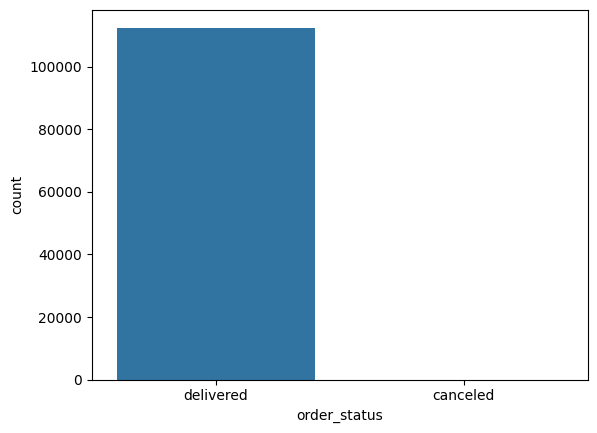

In [57]:
sns.countplot(data=df_notna, x="order_status")

#### **Product Category**

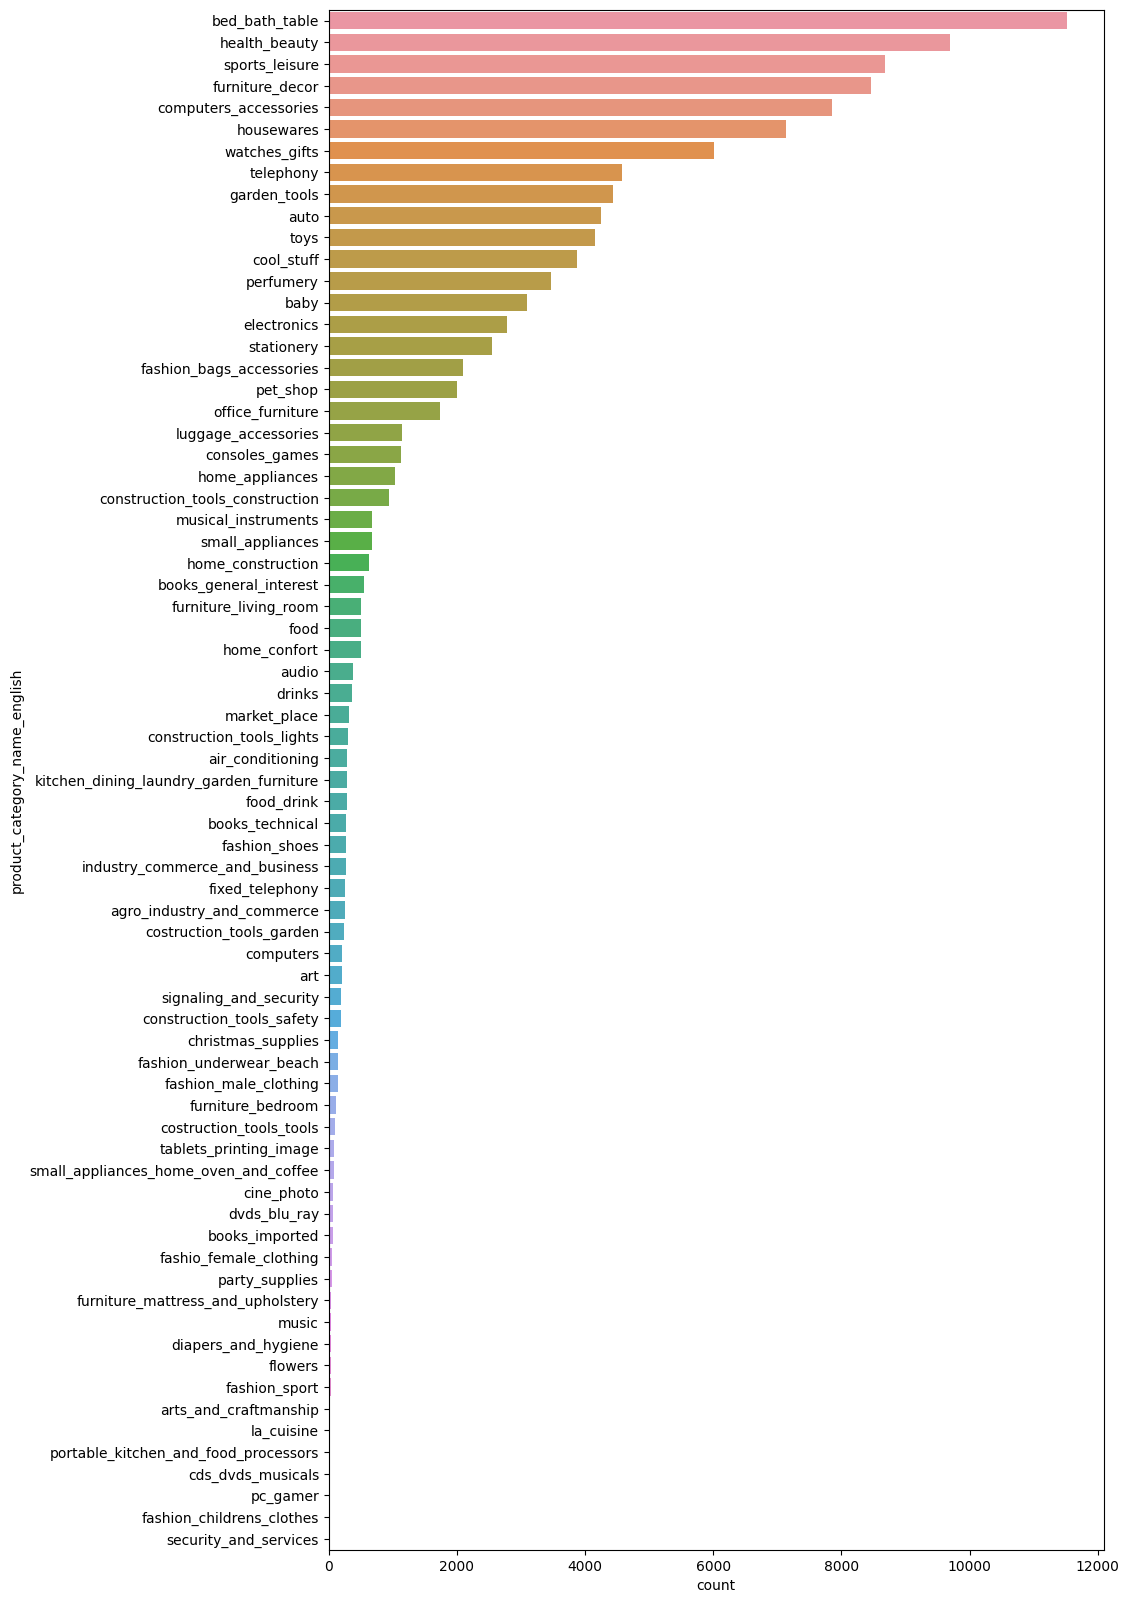

In [58]:
order = df_notna["product_category_name_english"].value_counts().index
plt.figure(figsize=(10,20))
sns.countplot(data=df_notna, y="product_category_name_english", order=order);

#### **Payment Type**

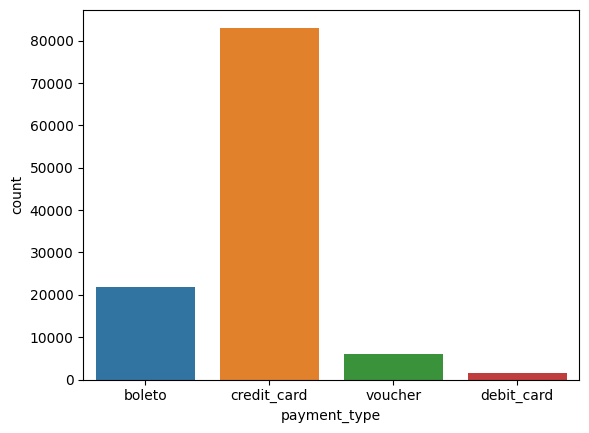

In [59]:
sns.countplot(data=df_notna, x="payment_type");

### **Numerical, Ordinal**

#### **Payment Sequential**

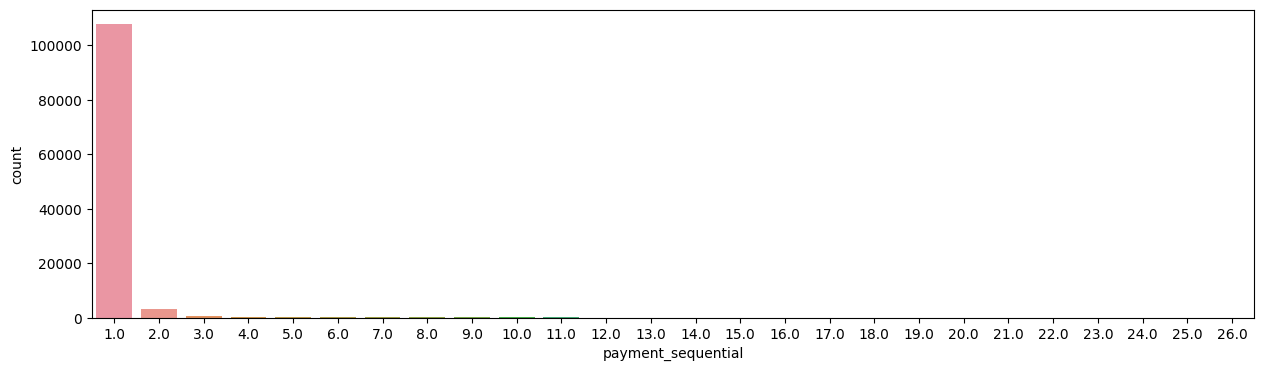

In [60]:
plt.figure(figsize=(15,4))
sns.countplot(data=df_notna, x="payment_sequential");

#### **Payment Installments**

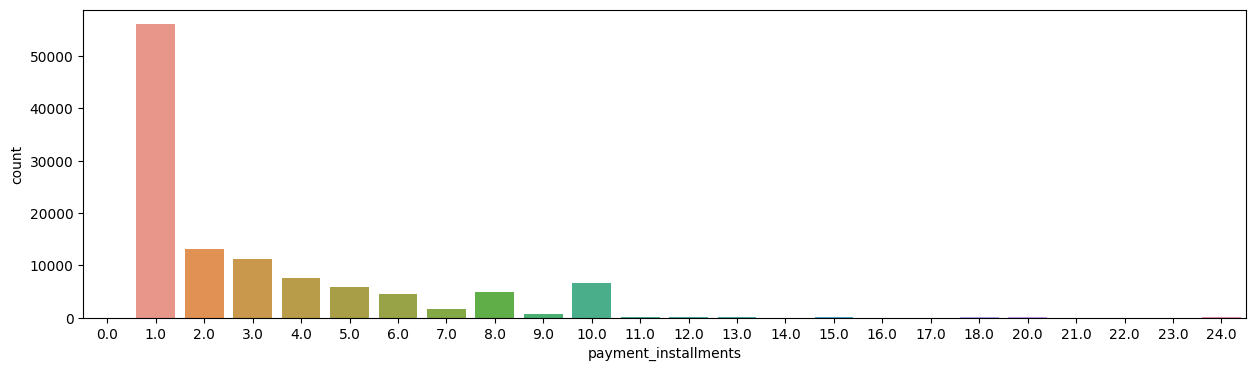

In [61]:
plt.figure(figsize=(15,4))
sns.countplot(data=df_notna, x="payment_installments");